In [600]:

import sys
import pandas as pd
import numpy as np
import re 
import nltk 
import datetime 
import matplotlib.pyplot as plt
import uuid
import ujson
import sqlite3
import sys
import psycopg2
import shutil
import os
import logging 
import csv 
import timeit


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD

from nltk.corpus import stopwords
from nltk import SnowballStemmer

from scipy.sparse import hstack


In [530]:
# OPTIONS 
DOPLOT = 1
SAVE_TO_DATABASE = 0

In [630]:

# FEATURE GENERATION 

OVERLAP_MODE = 'remove'
DO_REPEAT_SCORE = 1
DOTEST = 0
DO_NUM_NONZERO = 0
DO_NUM_REPEATS = 0 
DO_TOKENIZE_AND_STEM=0
DO_CURSEWORD_COUNT = 1
DO_CUSTOM_STOPWORDS = 1

def tokenize_and_stem(comment, stemmer = SnowballStemmer("english")):
    """
    Takes a reddit comment and stemmer as input
    and returns a list of stemmed words
    
    params: 
        str comment: comment to stem 
        nltk.stemmer stemmer: nltk stemmer object 
        
    rtype: ls[str]
    """
    comment = comment.strip().split()
    stemmed_comment = [stemmer.stem(word) for word in comment]
    return stemmed_comment

# def generate_features( OVERLAP_MODE = 'remove', DO_REPEAT_SCORE = 1, 
#     DO_NUM_NONZERO = 0, DO_NUM_REPEATS = 0, DOTEST = 0):
#     """
#     bool DOTEST: should we run in test mode?
#     """


In [642]:

# CORPUS GENERATION 

#### Options ##############################################################

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# parameters for vectorizer
ANALYZER = "word" # unit of features are single words rather then phrases of words
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) # Range for n-grams
MAX_DF = 0.6  # Exclude words that are contained in more than x percent of documents
MIN_DF = 50   # Exclude words that appear in less than 50 documents 

###########################################################################
# read in data
test_file = 'data/test.csv'
train_file = 'data/train.csv'

tr = pd.read_csv(train_file)
te = pd.read_csv(test_file)

if DOTEST:
    tr = tr.iloc[1:10000]
    te = te.iloc[1:10000]
    MIN_DF = 50
    MAX_DF = 1.0
    
Ntr = tr.shape[0]
Nte = te.shape[0]

logging.info( """
    Options
    OVERLAP_MODE: {}
    DO_REPEAT_SCORE: {}
    DOTEST: {}

    ANALYZE: {}
    STRIP_ACCENTS: {}
    TOKENIZER: {}
    NGRAM_RANGE: {}
    MAX_DF: {}
    MIN_DF: {}
    """.format( OVERLAP_MODE, DO_REPEAT_SCORE, DOTEST, ANALYZER, \
        STRIP_ACCENTS, TOKENIZER, NGRAM_RANGE, MAX_DF, MIN_DF) )

train_ids = tr.id
test_ids = te.id

def preprocess_comment( comment, RE_PREPROCESS = \
    re.compile(r""" \W + # one or more nonword characters
        |    # the or operator
        \d+  # digits""", re.VERBOSE), 
    URL_PREPROCESS = re.compile(r"""[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)""", \
        re.VERBOSE)):
    """
    str comment:
    compiled regular expression: RE_PREPROCESS 
    """
    return re.sub( RE_PREPROCESS, ' ', comment).lower()

if DO_TOKENIZE_AND_STEM:
    TOKENIZER = tokenize_and_stem
else: 
    TOKENIZER = None 
    
if DO_CUSTOM_STOPWORDS:
    with open( 'wordlists/toxic_stopwords.csv', 'r') as f:  
        reader = csv.reader(f)
        stopword_list = list(reader)
        stopword_list = [l[0] for l in stopword_list]
    
start = timeit.default_timer()
tr_vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer = TOKENIZER, 
                            ngram_range=NGRAM_RANGE,
                            preprocessor = preprocess_comment, 
                            stop_words = stopwords.words('english') + stopword_list,
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

te_vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer = TOKENIZER, 
                            ngram_range=NGRAM_RANGE,
                            preprocessor = preprocess_comment,
                            stop_words = stopwords.words('english') + stopword_list,
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

# tokenize
train_bag_of_words = tr_vectorizer.fit_transform( tr['comment_text'])
test_bag_of_words = te_vectorizer.fit_transform( te['comment_text'])

stop = timeit.default_timer()
runtime = stop - start
logging.info("Vectorization took {} seconds".format(runtime))

# get vocabulary lists 
tr_vocab = tr_vectorizer.get_feature_names()
te_vocab = te_vectorizer.get_feature_names()
vocab_overlap = set(tr_vocab).intersection(te_vocab)

logging.info( """Size train vocab = {}
              Size test vocab = {}
              Size overlap = {}""".format( len(tr_vocab), len(te_vocab), len(vocab_overlap) ) )

# if OVERLAP_MODE:
#     logging.info("Removing overlapping vocabulary in test and train")
#     # compute percent overlap in vocabulary
#     overlap = set(tr_vocab).intersection( te_vocab )

#     # Remove any features that aren't in both training and test
#     train_in_overlap  = [i for i, word in enumerate(tr_vocab) if word in overlap]
#     test_in_overlap  = [i for i, word in enumerate(te_vocab) if word in overlap]
#     tr_vocab = [tr_vocab[i] for i in train_in_overlap]
#     te_vocab = [te_vocab[i] for i in test_in_overlap]
#     train_bag_of_words = train_bag_of_words[:,train_in_overlap]
#     test_bag_of_words = test_bag_of_words[:, test_in_overlap]


# return train_bag_of_words, test_bag_of_words, train_feat, test_feat

INFO:root:
    Options
    OVERLAP_MODE: remove
    DO_REPEAT_SCORE: 1
    DOTEST: 0

    ANALYZE: word
    STRIP_ACCENTS: unicode
    TOKENIZER: None
    NGRAM_RANGE: (0, 2)
    MAX_DF: 0.6
    MIN_DF: 50
    
INFO:root:Vectorization took 89.5214981189929 seconds
INFO:root:Size train vocab = 10260
              Size test vocab = 9212
              Size overlap = 8553


In [643]:
# vectorizer = CountVectorizer(analyzer=ANALYZER,
#                             tokenizer = tokenize_and_stem, 
#                             ngram_range=NGRAM_RANGE,
#                             preprocessor = preprocess_comment, 
#                             stop_words = stopwords.words('english') + stopword_list,
#                             strip_accents=STRIP_ACCENTS,
#                             min_df = 1,
#                             max_df = 1)

# analyze = vectorizer.build_analyzer()
# analyze('wikipedia links are running wild')

In [644]:
# Check out vocabulary 
count_totals = train_bag_of_words.sum(0).getA()
for i in range(0,100,10):
    print("{}th percentile = {}".format(i, np.percentile( count_totals, i)))
    
# Print most common and least common words 
count_idx = count_totals.argsort()
print('\n')
for i in count_idx[0][:10]:
    print("{} = {} ".format( tr_vectorizer.get_feature_names()[i], count_totals[0][i] ) )

print('\n')
for i in count_idx[0][-20:]:
    print("{} = {} ".format( tr_vectorizer.get_feature_names()[i], count_totals[0][i] ) )


0th percentile = 50.0
10th percentile = 64.0
20th percentile = 76.0
30th percentile = 90.0
40th percentile = 111.0
50th percentile = 141.0
60th percentile = 187.39999999999964
70th percentile = 270.0
80th percentile = 441.2000000000007
90th percentile = 898.1000000000004


tried add = 50 
additionally users = 50 
site promote = 50 
generous = 50 
enough warrant = 50 
hello thanks = 50 
disservice = 50 
since seems = 50 
entry categories = 50 
tutorial picture = 50 


still = 7935 
two = 7986 
take = 8017 
wiki = 8095 
someone = 8125 
look = 8254 
read = 8310 
add = 8411 
right = 8589 
point = 8603 
since = 8688 
work = 8843 
find = 8997 
discussion = 9130 
thank = 9905 
fuck = 10085 
need = 10179 
editing = 10360 
thanks = 13911 
please = 29796 


In [689]:
x = tr.iloc[i][class_names].get_values()


0

In [690]:
# See if we have any training comments with no features 
comment_feature_counts = train_bag_of_words.sum(1).getA()
indices = np.where( comment_feature_counts == 0)[0]

for i in indices: 
    label_values = tr.iloc[i][class_names].get_values()
    if label_values.any():
        print( '***************************************************\n')
        print( tr['comment_text'].iloc[i] + '\n')
        print( tr.iloc[i][class_names].get_values() )


***************************************************

P.S. Are you a /b/tard?

[1 0 0 0 0 0]
***************************************************

n i g g e r f a g g o t

[1 1 0 0 0 1]
***************************************************

Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I know you? 

BeCauSe You aRe a FGGT!
 Do I kn

[1 0 0 0 0 0]
***************************************************

You. 

I despise you.

[1 0 0 0 0 0]
***************************************************

I like pee farts 

Poo poo in the potty

[1 0 0 0 0 0]
***************************************************

all chinks and gooks should be deported

[1 0 1 0 1 1]
***************************************************

Go F yourself you cottonheadednittymuggins.

[1 0 0 0 0 0]
***************************************************

islams you mutha F***ers

[1 1 1 0 1 0]
***************************************************

Get out my talk page you smelling wog!

[1 0 1 0 1 0]
***************************************************

f u c k  y o u  a s  u  a r e  a  b i t c h  a s s  n i g g e r

[1 0 1 0 1 1]
***************************************************

I don't like you 

! 77.184.28.171

[1 0 0 0 0 0]
***************************************************

Do I know you? ==BeCauSe You aRe a FGGT!
 Do I know you? BeCauSe You aRe a FGGT!

[1 0 0 0 0 0]
***************************************************

IS AN OBESE HORE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[1 0 1 0 0 0]
***************************************************

fffffffff   uuuuuu     uuuuu   ccccccccccccc  kkkkk   uuuuuuuuu
fffffffff   uuuuuu     uuuuu   ccccccccccccc
fffff       uuuuuu     uuuuu   cccc
fffffffff   uuuuuu     uuuuu   cccc
fffffffff   uuuuuu     uuuuu   cccc
fffff       uuuuuu     uuuuu   cccc
fffff       uuuuuuuuuuuuuuuu   cccccccccccc
fffff       uuuuuuuuuuuuuuuu   cccccccccccc

[1 0 1 0 1 0]
***************************************************

No 

F*** off coon! 86.179.112.61

[1 0 1 0 0 0]
***************************************************

fok you 

YOU SUK BITSH FOCK YOU

[1 1 1 0 1 0]
***************************************************

Regents licks a taintOPENLYGAY

[1 0 0 0 1 1]
***************************************************

You're such a slut.

[1 0 1 0 1 0]
**********************


Beeblebrox, you f*cking prost!tute 

Beeblebrox, you brainless f*cking prost!tute.

[1 1 1 0 1 0]
***************************************************

F UCK YOU 

F UCK YOU SUGGESTBOT

[1 0 1 0 1 0]
***************************************************

Who made you sherrif you shitsack?

[1 0 1 0 1 0]
***************************************************

your a retarted shithead

[1 0 1 0 1 0]
***************************************************

I ant all the bithces

[1 0 1 0 0 0]
***************************************************

you are all perverted pedophiles

[1 0 0 0 0 0]
***************************************************

o no all these bastardsllpaybad

[1 0 0 0 0 0]
***************************************************

BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, B

***************************************************

Also he is a.w.f.u.l.

[1 0 0 0 0 0]
***************************************************

Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Bastered You Bastered==Baster

In [606]:
# PRE VECTORIZED FEATURE GENERATION 

# regexp preprocessing
RE_PREPROCESS = re.compile(r""" \W + # one or more nonword characters
                               |    # the or operator
                               \d+  # digits""", re.VERBOSE)
train_comments = list( tr.comment_text )
test_comments = list( te.comment_text )
processed_tr_comments = [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in train_comments]
processed_te_comments = [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in test_comments] 

train_feat = pd.DataFrame( index = tr.index )
test_feat = pd.DataFrame( index = te.index )

# Generate repeat score
if DO_REPEAT_SCORE:
    logging.info("Computing repeat score")
    
    tr_num_nonzero, tr_repeat_score, tr_num_repeats = [], [], []
    for comment in processed_tr_comments:
        vec = comment.strip().split() 
        tr_num_nonzero.append( len(set(vec)))
        tr_num_repeats.append( len(vec))
        tr_rep_score = ( len( set( vec)) + 1)/(len(vec) + 1) - 1
        tr_repeat_score.append( tr_rep_score) 
        
    te_num_nonzero, te_repeat_score, te_num_repeats = [], [], []
    for comment in processed_te_comments:
        vec = comment.strip().split() 
        te_num_nonzero.append( len(set(vec)))
        te_num_repeats.append( len(vec))
        te_rep_score = ( len( set( vec)) + 1)/(len(vec) + 1) - 1
        te_repeat_score.append( te_rep_score) 

    # Create Feature DataFrame
    test_feat['repeat_score'] = te_repeat_score
    train_feat['repeat_score'] = tr_repeat_score 

    
if DO_NUM_NONZERO:
    train_feat['num_nonzero'] = tr_num_nonzero
    test_feat['num_nonzero'] = te_num_nonzero
    
if DO_NUM_REPEATS: 
    test_feat['num_repeats'] = te_num_repeats
    train_feat['num_repeats'] = tr_num_repeats

INFO:root:Computing repeat score


In [ ]:
#analyze = tr_vectorizer.build_analyzer()


In [494]:
# CURSE WORD COUNTER 
if DO_CURSEWORD_COUNT: 
    curseword_file = 'wordlists/cursewords.csv'
    curseword_list = []
    with open( curseword_file , 'r') as f:
        reader = csv.reader(f)
        curseword_list = list(reader)

    curseword_list = [l[0] for l in curseword_list]

    # regexp preprocessing 
    # (Different than for repeat_score, we're keeping digits because some cursewords contain digits, 
    # e.g., assh0le )
    RE_PLUS_URL_PREPROCESS = re.compile(r"""\W+ | [-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)""", re.VERBOSE)
    train_comments = list( tr.comment_text )
    test_comments = list( te.comment_text )
    processed_tr_comments = [ re.sub(RE_PLUS_URL_PREPROCESS, ' ', comment).lower() \
                             for comment in train_comments]
    processed_te_comments = [ re.sub(RE_PLUS_URL_PREPROCESS, ' ', comment).lower() \
                             for comment in test_comments] 

    curse_overlap = set(curseword_list).intersection( tr_vectorizer.get_feature_names() )
    train_curse_indices = [ tr_vectorizer.get_feature_names().index( word ) for word in curse_overlap]
    
    curse_overlap = set(curseword_list).intersection( te_vectorizer.get_feature_names() )
    test_curse_indices = [ te_vectorizer.get_feature_names().index( word ) for word in curse_overlap]

    train_feat['curseword_count'] = train_bag_of_words[:, train_curse_indices].sum(1)
    test_feat['curseword_count'] = test_bag_of_words[:, test_curse_indices].sum(1)

In [495]:
train_features = hstack(  (train_bag_of_words, train_feat), dtype = 'float64').tocsr()  
test_features = hstack(  (test_bag_of_words, test_feat), dtype = 'float64' ).tocsr()  

class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

logging.info( """Size of train features = ({},{}), 
    Size of test features = ({},{})""".format(train_features.shape[0], \
    train_features.shape[1], test_features.shape[0], test_features.shape[1]))

In [496]:
# Create output table 
if SAVE_TO_DATABASE: 
    try:
        conn = psycopg2.connect("host=localhost dbname=toxic_ml_output user=postgres")
    except:
        print("I am unable to connect to the database")


    # create cursor 
    c = conn.cursor()

    if refresh_database:
        print("Dropping classifiers table and removing Results/preds")
        c.execute('DROP TABLE classifiers')
        try: 
            shutil.rmtree('./Results/preds') 
        except:
            print("directory ./Results/preds does not exist")

    os.makedirs('./Results/preds')    

    c.execute('''CREATE TABLE IF NOT EXISTS classifiers (
                 model_id text,
                 model_type text, 
                 model_params json, 
                 valid_filenm text, 
                 test_filenm text, 
                 auc json, 
                 mean_auc double precision)''')

    conn.commit()
    conn.close()

In [531]:
# PCA on the data 
if DOPLOT:
    tsvd = TruncatedSVD(n_components=2)
    X_r = tsvd.fit(train_bag_of_words).transform( train_bag_of_words) 
    

Number toxic = 15294, number not toxic = 144277
Number severe_toxic = 1595, number not severe_toxic = 157976
Number obscene = 8449, number not obscene = 151122
Number threat = 478, number not threat = 159093
Number insult = 7877, number not insult = 151694
Number identity_hate = 1405, number not identity_hate = 158166


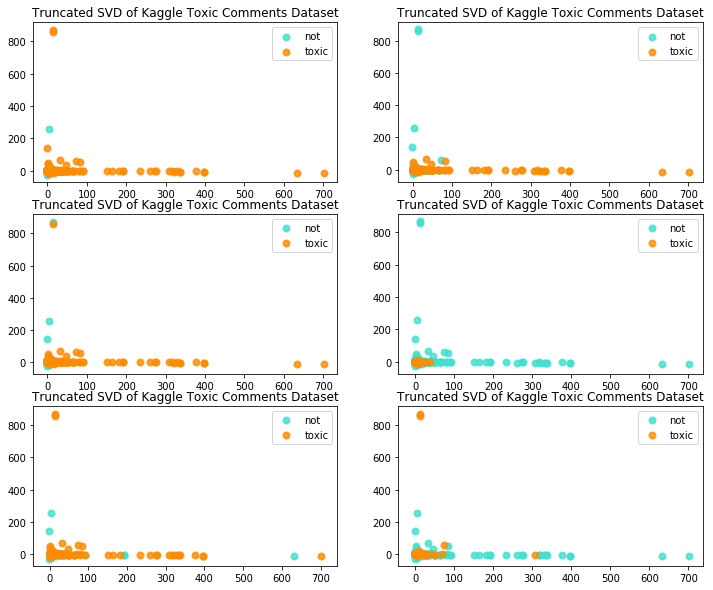

In [532]:
if DOPLOT: 
    plt.figure(figsize = (12, 10))
    for c, class_now in enumerate(class_names): 
        labels_now = tr_classes[class_now]
        print( "Number {} = {}, number not {} = {}".format(class_now, \
            sum( labels_now == 1), class_now, sum( labels_now == 0) ))
        

        plt.subplot( 3, 2, c+1 )
        colors = ['turquoise', 'darkorange']
        target_names = ['not', 'toxic']
        lw = 2

        for color, i, target_name in zip(colors, [0, 1], target_names):
             plt.scatter(X_r[labels_now == i, 0], X_r[labels_now == i, 1], color = color, alpha=.8, lw=lw,
                 label=target_name)

        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.title('Truncated SVD of Kaggle Toxic Comments Dataset')
    plt.show() 

In [499]:
valid_out = pd.DataFrame( index = tr.index, columns = class_names, dtype = 'float64' )
# out['id'] = train_ids

In [500]:
# Create Train and Validation Splits 
logistic_regression = LogisticRegression()

param_grid = [
  {'C': [1e-2, 1e-1, 1, 1e1, 1e2], 'penalty': 'l2'},
  {'C': [1e-2, 1e-1, 1], 'penalty': 'l1'}
 ]

KFold(n_splits=2, random_state=None, shuffle=True)

KFold(n_splits=2, random_state=None, shuffle=True)

In [501]:
## NESTED CROSS VALIDATION 
# Optimize classifier over hyperparams and score for each class 

# We split our training data as follows: training=[train, validate, test] 
# The outer cv loop is outer_train = [train, validate], outer_test = test partitions
# The innner loop is inner_trian = train (outer_train[0]) and 
# inner_test = validate (outer_train[1])

# make scorer for inner cross validation loop 
roc_auc_scorer = make_scorer(roc_auc_score)


for class_now in class_names:
        
    logging.info("Fitting models for {} classifier".format( class_now))
    # outer cross validation partition 
    outer_cv = KFold(n_splits=2, shuffle=True, random_state=i)

    # for each outer cv partition 
    for train_index, test_index in outer_cv.split( train_bag_of_words ):
        
        X_train, X_test = train_features[train_index,:], train_features[test_index,:]
        Y_train, Y_test = tr_classes[class_now].iloc[train_index], \
            tr_classes[class_now].iloc[test_index]
       
        # inner cv loop 
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=1)
       
        # optimize hyperparameters and return best perfoming classifier
        clf = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, \
                           scoring = roc_auc_scorer, cv=inner_cv )
        clf.fit(X_train, Y_train) # inner cv loop over outer training data 
        
        # predict on outer test set 
        Y_score = clf.predict_proba( X_test )
    
        # store predictions  
        valid_out[class_now].iloc[test_index] = Y_score[:,1]


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [502]:
# OLD Non-nested fitting routine 

# # Fit classifier on folds 
# for class_now in class_names:
#     for train_index, valid_index in kf.split(train_bag_of_words):
#         # print("TRAIN:", train_index, "VALID:", valid_index)
#         X_train, X_valid = train_features[train_index,:], train_features[valid_index,:]
#         Y_train, Y_valid = tr_classes[class_now].iloc[train_index], \
#             tr_classes[class_now].iloc[valid_index]
#         id_train, id_valid = train_ids[train_index], train_ids[valid_index]
    
#         # Fit Model 
#         mdl = clf.fit(X_train, Y_train) 
    
#         # Predict Validation Set 
#         Y_score = mdl.predict_proba( X_valid )
    
#         # Store Predicted Probabilities 
#         valid_out[class_now].iloc[valid_index] = Y_score[:,1]

In [508]:
print( clf ) 

print( train_features.shape ) 

print( tr_vectorizer )

GridSearchCV(cv=KFold(n_splits=2, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10.0, 100.0], 'penalty': ['l2', 'l1']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)
(159571, 9976)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=50,
        ngram_range=(0, 2),
        preprocessor=<function preprocess_comment at 0x255001510>,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'ou

In [503]:
AUC = dict()
AUC = {class_now:  roc_auc_score( tr[class_now], valid_out[class_now]) \
       for class_now in class_names}


In [504]:
AUC2 = pd.DataFrame.from_dict( AUC , orient = 'index')
print("Validation: Mean Column-wise AUC = {}".format(AUC2.mean().to_string( index=False)))
print(AUC)

Validation: Mean Column-wise AUC = 0.868258
{'toxic': 0.9258654671005184, 'severe_toxic': 0.8323765381289615, 'obscene': 0.9651337325718291, 'threat': 0.8366288058612175, 'insult': 0.8827465152174491, 'identity_hate': 0.7667962863288416}


In [303]:
test_out = pd.DataFrame( index = test_ids, columns = class_names )

In [114]:
# Predict on Test Data 
for class_now in class_names: 
    
    # fit classifier 
    mdl = clf.fit(train_features, tr_classes[class_now]) 
    
    # Predict Validation Set 
    Y_score = mdl.predict_proba( test_features )
    
    # Store Predicted Probabilities 
    test_out[class_now][test_ids] = Y_score[:,1]
    
### ISSUE: Number of features in training and test is not the same! 
    

/usr/local/Cellar/ipython/6.2.1_1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [27]:
if SAVE_TO_DATABASE: 
    # create train/test save filesnames 
    classifier_name = uuid.uuid4().hex
    valid_save_filename = 'Results/preds/' + classifier_name + '_train'
    test_save_filename = 'Results/preds/' + classifier_name + '_test'

    # save train and test output 
    valid_out.to_pickle( train_save_filename )
    test_out.to_pickle( test_save_filename )

    # store classifier in database 
    conn = psycopg2.connect("host=localhost dbname=toxic_ml_output user=postgres")
    c = conn.cursor() 

    #              model_id text,
    #              model_type text, 
    #              model_params json, 
    #              valid_filenm text, 
    #              test_filenm text, 
    #              auc json, 
    #              mean_auc real)'''

    c.execute('''INSERT INTO classifiers(model_id, model_type, 
        model_params, valid_filenm, test_filenm, auc, mean_auc) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)''', \
        (classifier_name, 'LR', ujson.dumps(clf.get_params()), \
         train_save_filename, test_save_filename, \
         ujson.dumps(AUC), AUC2.mean()[0] ))

    conn.commit()
    conn.close()

In [359]:
class_names

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [509]:
pd.options.display.max_colwidth = 1000

# Print out most toxic comments 
display_class = 'identity_hate'
toxic_out = test_out.sort_values( by = display_class, ascending = 0 )
num_to_visualize = 5

for i in range(0, num_to_visualize):    
    id_now = toxic_out.index[i]
    comment_now = te[te['id'] == id_now]['comment_text']
    print( "Id = {}, {} = {}, comment =\n {}\n".format( id_now, \
        display_class, toxic_out['toxic'][i], comment_now))

Id = 00001cee341fdb12, identity_hate = nan, comment =
 0    Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
Name: comment_text, dtype: object

Id = 0000247867823ef7, identity_hate = nan, comment =
 1    == From RfC == \n\n The title is fine as it is, IMO.
Name: comment_text, dtype: object

Id = 00013b17ad220c46, identity_hate = nan, comment =
 2    " \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "
Name: comment_text, dtype: object

Id = 00017563c3f7919a, identity_hate = nan, comment =
 3    :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again b

In [101]:
# Print out most misclassified comments 
diff = tr[class_names].subtract( valid_out).abs()


In [527]:
tr_vectorizer.vocabulary_.get('anus')

631

In [511]:
sort_class = 'identity_hate' # ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
diff  = diff.sort_values( by = sort_class, ascending = 0 )
diff.head()

for i in range(0, num_to_visualize):    
    id_now = diff.index[i]
    comment_now = tr[tr.index == id_now]['comment_text']
    print( "Id = {}, {} = {}\n".format( id_now, sort_class, \
        valid_out.iloc[valid_out.index == id_now][sort_class].iat[0], comment_now))
    print( comment_now )
    print( processed_tr_comments[id_now])

Id = 56981, identity_hate = 1.6580154654319564e-10

56981    adding twitter spam? \n\nMaybe it is interesting to add a paragraph on twitter spam? Im not so familiar with it, but we have it a lot on out twitter account, like innovative ways of spamming, see for example http://blog.twitter.com/2008/08/making-progress-on-spam.html and maybe there are other innovative spamming ways too?    \n\nshit shioty ashit shit shgit shit shit shoit shot ahot aot shoit shit shit shit shit shit shit shit shit hsoit shiot sht shot shti sot shot shut shyt shit shioty ashit shit shgit shit shit shoit shot ahot aot shoit shit shit shit shit shit shit shit shit hsoitshit shioty ashit shit shgit shit shit shoit shot ahot aot shoit shit shit shit shit shit shit shit shit hsoit shiot sht shot shti sot shot shut shyt  shiot sht shot shti sot shot shut shyt shit shioty ashit shit shgit shit shit shoit shot ahot aot shoit shit shit shit shit shit shit shit shit hsoit shiot sht shot shti sot shot shut shyt shit sh

'Shut up you asswipe we don t care I ll decapitate your mother and shit down her his neck Go back to Jewland you fuck http http '

In [203]:
sort_index = np.argsort( abs( clf.coef_ ))[::-1][:10]
sort_index2 = np.argsort( abs( clf.coef_ ))[:10]

sort_index = abs( clf.coef_ ).argsort()[:10]
sort_index2= (-abs( clf.coef_ )).argsort()[:10]

In [523]:
# Print out model weights 

# sorted_coefficients = sorted( abs(clf.coef_)
num_to_visualize = 30
sort_index = np.argsort( -abs( clf.best_estimator_.coef_ ))

for i in np.nditer(sort_index[0][0:num_to_visualize], order = "C"): 
    print("{:10.10}, {:20.25}, {}".format( clf.best_estimator_.coef_.item(i), tr_vocab[i], 
            tr_vectorizer.vocabulary_[tr_vocab[i]] ) )
    

idx = tr_vocab.index("nigger")
print("{:10.10}, {:20.25}, {}".format( clf.best_estimator_.coef_.item(idx), tr_vocab[idx], 
    tr_vectorizer.vocabulary_[tr_vocab[idx]] ) )

-3.097439162, im go               , 5053
2.845068046, abl see             , 16
2.550312764, fuck faggot         , 4262
2.500072397, fuck stupid         , 4269
-2.47858646, wanker              , 11746
-2.435026507, sep                 , 9580
-2.422778049, goddamn             , 4528
-2.394372501, block expir         , 1491
-2.391132788, lista               , 6023
2.323708027, wikipedia foundat   , 12124
-2.265276499, novemb utc          , 7081
2.26096377, realli interest     , 8687
-2.228743202, write someth        , 12493
-2.190374389, take issu           , 10519
2.182327071, go find             , 4486
2.127104359, everi articl        , 3714
2.120792301, nigga               , 6964
-2.0633715, import low          , 5113
-2.049538274, defect              , 2766
-2.008628142, provid use          , 8424
2.006438063, address make        , 189
-2.000365029, final pleas         , 4022
-1.957046061, come conclus        , 2110
-1.951997999, whi mention         , 11996
1.932695636, page tell     

In [521]:
cv_results = pd.DataFrame( clf.cv_results_)
cv_results


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.108288,0.007826,0.514936,0.516686,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",9,0.516137,0.514101,0.513734,0.519271,1.012396,0.000420,0.001201,0.002585
1,0.289249,0.007995,0.505499,0.507661,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",10,0.505434,0.507070,0.505565,0.508252,0.020763,0.000015,0.000065,0.000591
2,3.548393,0.009483,0.525324,0.535504,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",7,0.518753,0.533906,0.531895,0.537102,0.688096,0.000115,0.006571,0.001598
3,3.793520,0.008898,0.519149,0.529260,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",8,0.525804,0.531035,0.512495,0.527485,0.007377,0.000271,0.006655,0.001775
4,3.118416,0.010188,0.530926,0.540917,1,l2,"{'C': 1, 'penalty': 'l2'}",6,0.518790,0.530984,0.543062,0.550850,0.246697,0.000353,0.012136,0.009933
5,4.884030,0.009192,0.551098,0.598592,1,l1,"{'C': 1, 'penalty': 'l1'}",3,0.564851,0.611809,0.537346,0.585374,0.018867,0.001150,0.013753,0.013218
6,3.366421,0.009486,0.532987,0.544464,10,l2,"{'C': 10.0, 'penalty': 'l2'}",5,0.520130,0.536726,0.545844,0.552202,0.115721,0.000171,0.012857,0.007738
7,767.287848,0.009068,0.572768,0.790346,10,l1,"{'C': 10.0, 'penalty': 'l1'}",2,0.580558,0.781832,0.564979,0.798860,20.260598,0.000156,0.007789,0.008514
8,3.463333,0.009624,0.537146,0.546595,100,l2,"{'C': 100.0, 'penalty': 'l2'}",4,0.525576,0.539584,0.548715,0.553605,0.267516,0.000415,0.011569,0.007010
9,538.473759,0.009791,0.601246,0.938343,100,l1,"{'C': 100.0, 'penalty': 'l1'}",1,0.613964,0.929178,0.588528,0.947507,52.949408,0.000394,0.012718,0.009164


In [525]:
tr_vectorizer.get_feature_names() == te_vectorizer.get_feature_names()

tr_vocab == te_vocab

True

In [31]:
# Prepare Submission File 
now = datetime.datetime.now()
test_out.to_csv("Results/test_submission_{}_{}_{}.csv".format(now.month, now.day, now.year)) 